# Creation of a regression model based on the Ames Housing Dataset to predict the sales price of a house.

In [1]:
#Importing of packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, SCORERS
from sklearn.feature_selection import mutual_info_regression,VarianceThreshold,f_regression,RFECV,RFE
from sklearn.preprocessing import StandardScaler

import itertools
from tqdm import tnrange, tqdm_notebook

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('ggplot')
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)

# Importing of the Training data

In [2]:
#Importing the training data from datasets folder
train_data = pd.read_csv('./datasets/train.csv')
train_data = train_data.drop(['Id','PID'],axis=1)
train_data.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,...,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,...,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,...,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,...,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,...,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


# EDA & Cleaning

In [3]:
#Counting the total rows and columns
train_data.shape

(2051, 79)

In [4]:
#Describing all numerical data
train_data.describe()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [5]:
#Brief overview of the number of null values.
train_data.isnull().sum()

MS SubClass          0
MS Zoning            0
Lot Frontage       330
Lot Area             0
Street               0
Alley             1911
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        22
                  ... 
Functional           0
Fireplaces           0
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Paved Drive          0
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Pool QC    

In [6]:
#identifying ordinal, discrete, nominal and continuous datas
ordinal = ['Lot Shape','Utilities','Land Slope','Overall Qual','Overall Cond','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC','Electrical','Kitchen Qual','Functional','Fireplace Qu','Garage Finish','Garage Qual','Garage Cond','Paved Drive','Pool QC','Fence']
continuous = ['Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area','Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area','Misc Val']
discrete = ['Year Built','Year Remod/Add','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath','TotRms AbvGrd','Fireplaces','Garage Yr Blt','Garage Cars','Mo Sold','Yr Sold']
nominal = [col for col in list(train_data.keys()) if col not in (discrete + ordinal + continuous + ['SalePrice'])]
ordcont = ordinal+continuous
onehot=discrete+nominal

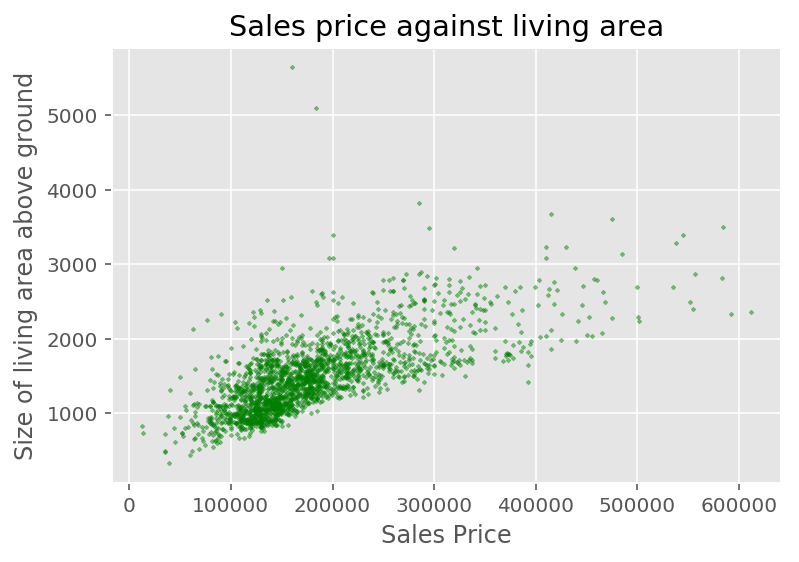

In [8]:
#visual identification of the 2 outliers with large area but relatively low price, as mentioned in data description from the data source
plt.scatter(train_data['SalePrice'],train_data['Gr Liv Area'],marker='x',c='g',s=2,alpha=0.5)
plt.xlabel('Sales Price')
plt.ylabel('Size of living area above ground')
plt.title('Sales price against living area')
plt.savefig('./graphs/2_large_outliers.png')

In [9]:
#removing the 2 unusually large houses that sold for good value as it is a major outlier.
train_data1=train_data.loc[(train_data['Gr Liv Area']<=4000)]

# EDA

In [10]:
#describing the continuous variables
train_data1[continuous].describe()

,Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val
count,1719.000000,2049.000000,2027.000000,2048.000000,2048.000000,2048.000000,2048.000000,2049.000000,2049.00000,2049.000000,2049.000000,2048.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000
mean,68.878999,10024.677892,98.797731,438.018555,48.005859,567.525391,1053.549805,1160.848219,329.18692,5.518302,1495.553441,472.878418,93.554417,47.224500,22.593948,2.593948,16.527574,2.165935,43.327965
std,22.472112,6608.511749,172.563846,439.843609,165.074675,445.019539,426.283435,379.066122,425.59571,51.093509,485.783577,214.501543,128.195671,65.857797,59.870165,25.241801,57.399890,36.297124,434.481342
min,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.00000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,58.000000,7500.000000,0.000000,0.000000,0.000000,220.000000,793.000000,879.000000,0.00000,0.000000,1128.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68.000000,9405.000000,0.000000,368.000000,0.000000,474.500000,994.000000,1092.000000,0.00000,0.000000,1444.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80.000000,11500.000000,160.000000,733.000000,0.000000,811.000000,1317.250000,1404.000000,691.00000,0.000000,1728.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,313.000000,159000.000000,1600.000000,2188.000000,1474.000000,2336.000000,3206.000000,3820.000000,1862.00000,1064.000000,3820.000000,1356.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,12500.000000


In [12]:
#exploring the date of sales that were collected.
pd.set_option("display.max_rows", 60)
train_data1[['Mo Sold','Yr Sold']].sort_values(by=['Yr Sold','Mo Sold'],axis=0, ascending=True)

,Mo Sold,Yr Sold
24,1,2006
221,1,2006
741,1,2006
761,1,2006
880,1,2006
938,1,2006
1093,1,2006
1130,1,2006
1247,1,2006
1314,1,2006


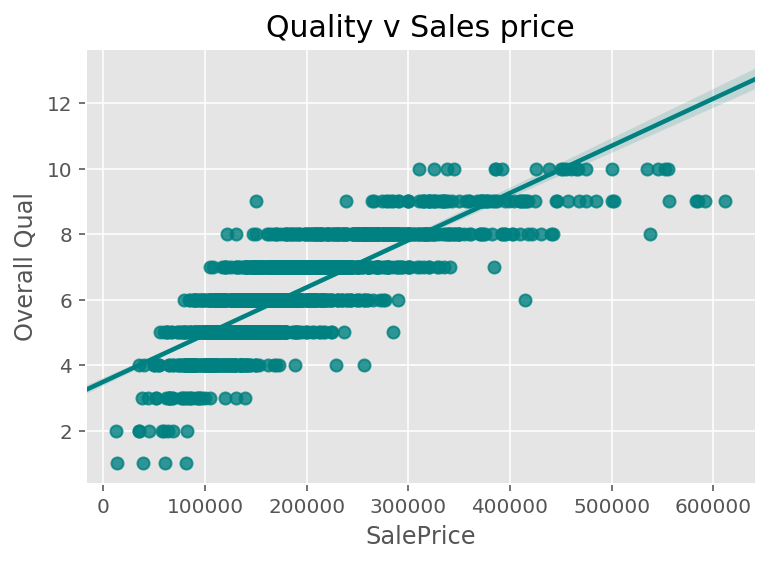

In [13]:
sns.regplot(train_data1['SalePrice'],train_data1['Overall Qual'],color='teal')
plt.title('Quality v Sales price',fontsize = 15)
plt.savefig('./graphs/Quality_v_Price')

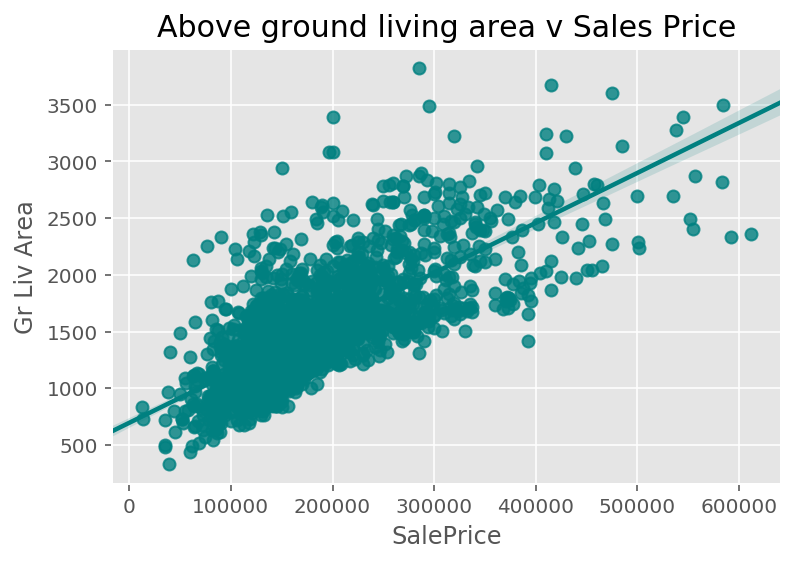

In [14]:
sns.regplot(train_data1['SalePrice'],train_data1['Gr Liv Area'], color = 'teal')
plt.title('Above ground living area v Sales Price',fontsize = 15)
plt.savefig('./graphs/Liv_area_v_Price')

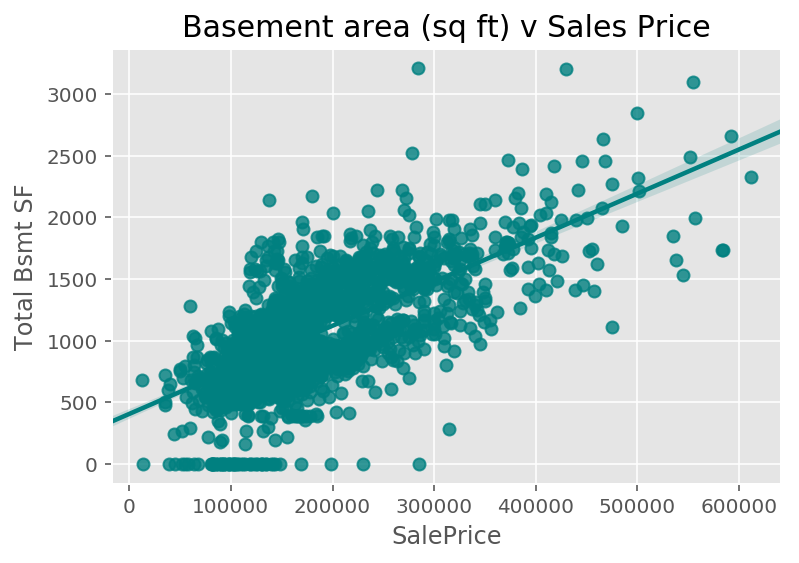

In [15]:
sns.regplot(train_data1['SalePrice'],train_data1['Total Bsmt SF'],color = 'teal')
plt.title('Basement area (sq ft) v Sales Price',fontsize = 15)
plt.savefig('./graphs/basement_v_Price')

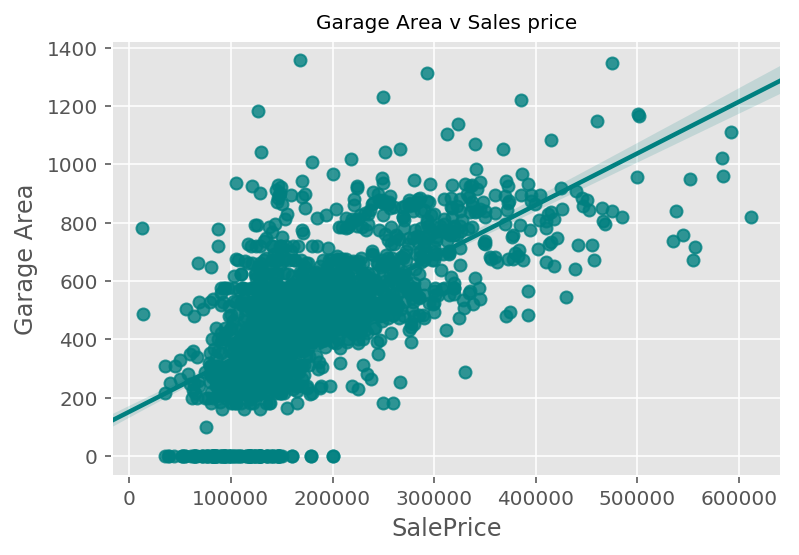

In [16]:
sns.regplot(train_data1['SalePrice'],train_data1['Garage Area'], color = 'teal')
plt.title('Garage Area v Sales price',fontsize = 10)
plt.savefig('./graphs/Garage_area_v_Price')

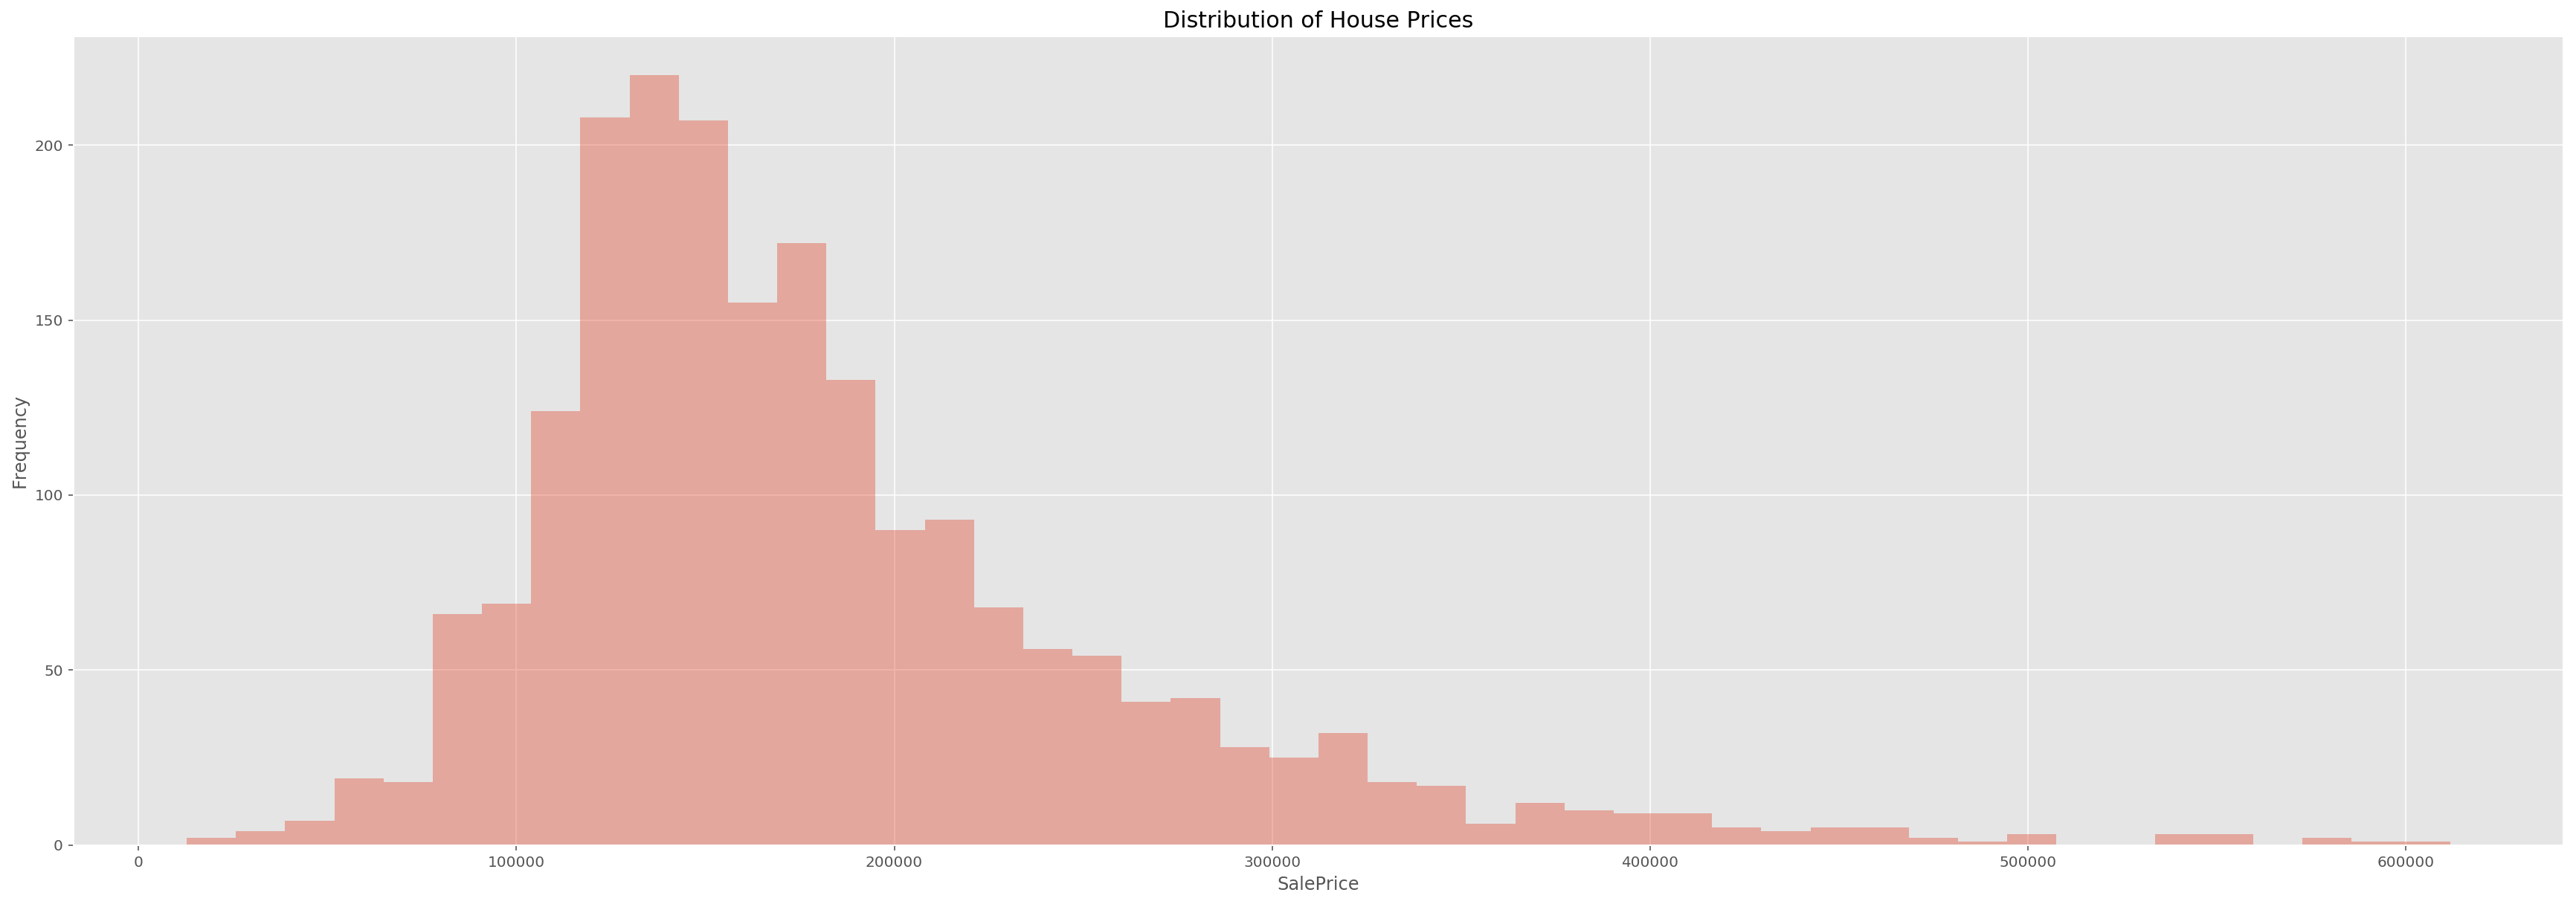

In [17]:
#Distribution of Sales Price
#try to show counts instead of probability density, and if able to show by the different type of property????
plt.figure(figsize=(30,10))
plt.title('Distribution of House Prices',fontsize=15)
plt.ylabel('Frequency')
sns.distplot(train_data1['SalePrice'],kde=False)
plt.savefig('./graphs/price_distribution');

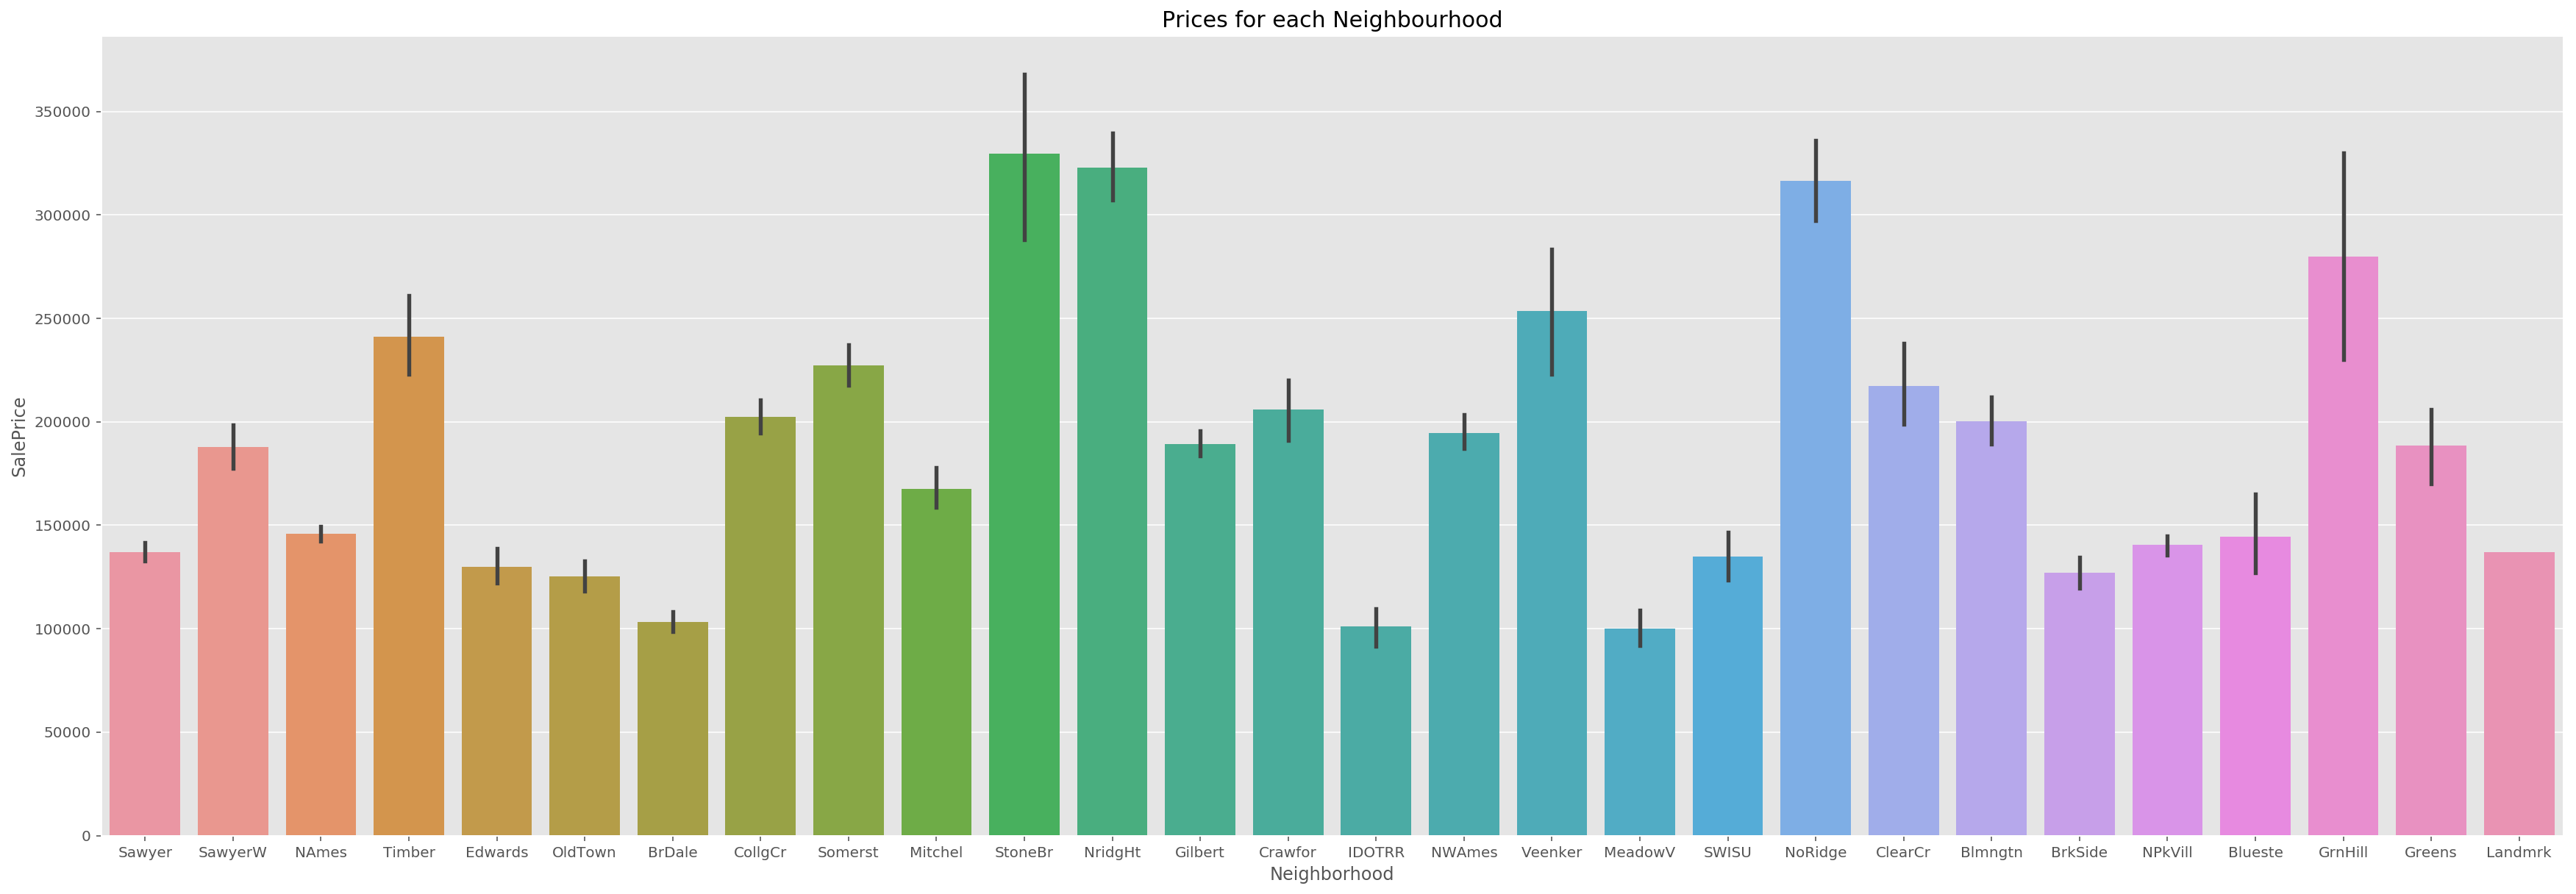

In [18]:
#Price per Neighbourhood
plt.figure(figsize=(30,10))
sns.barplot(x=train_data1['Neighborhood'],y=train_data1['SalePrice'])
plt.title('Prices for each Neighbourhood',fontsize=15)
plt.savefig('./graphs/price_neighborhood_distribution');

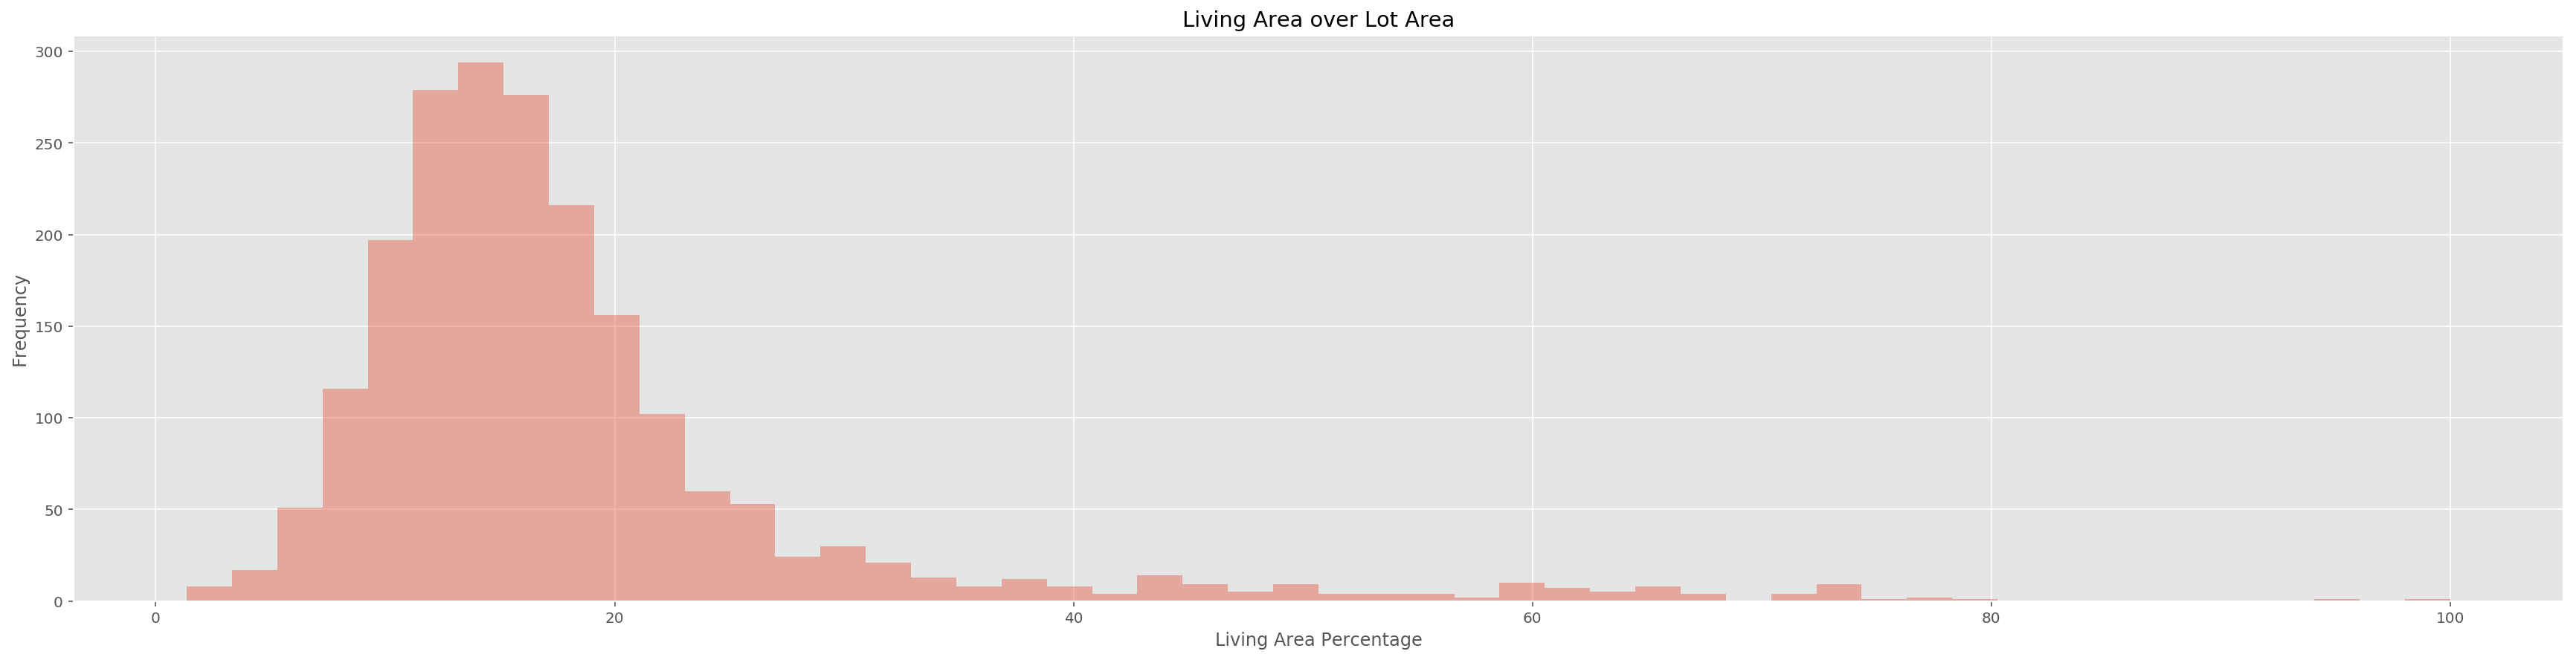

In [19]:
# Gross Living Area as a percentage of total Lot Area
plt.figure(figsize=(30,7))
plt.title('Living Area over Lot Area')
plt.xlabel('Living Area Percentage')
plt.ylabel('Frequency')
sns.distplot(100*train_data1['Gr Liv Area']/train_data1['Lot Area'],hist=True,kde=False)

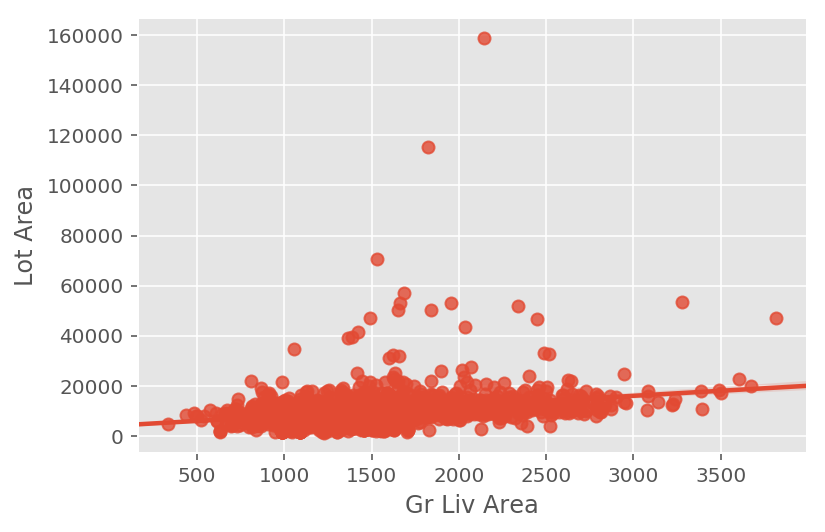

In [20]:
sns.regplot(x=train_data1['Gr Liv Area'],y=train_data1['Lot Area'])

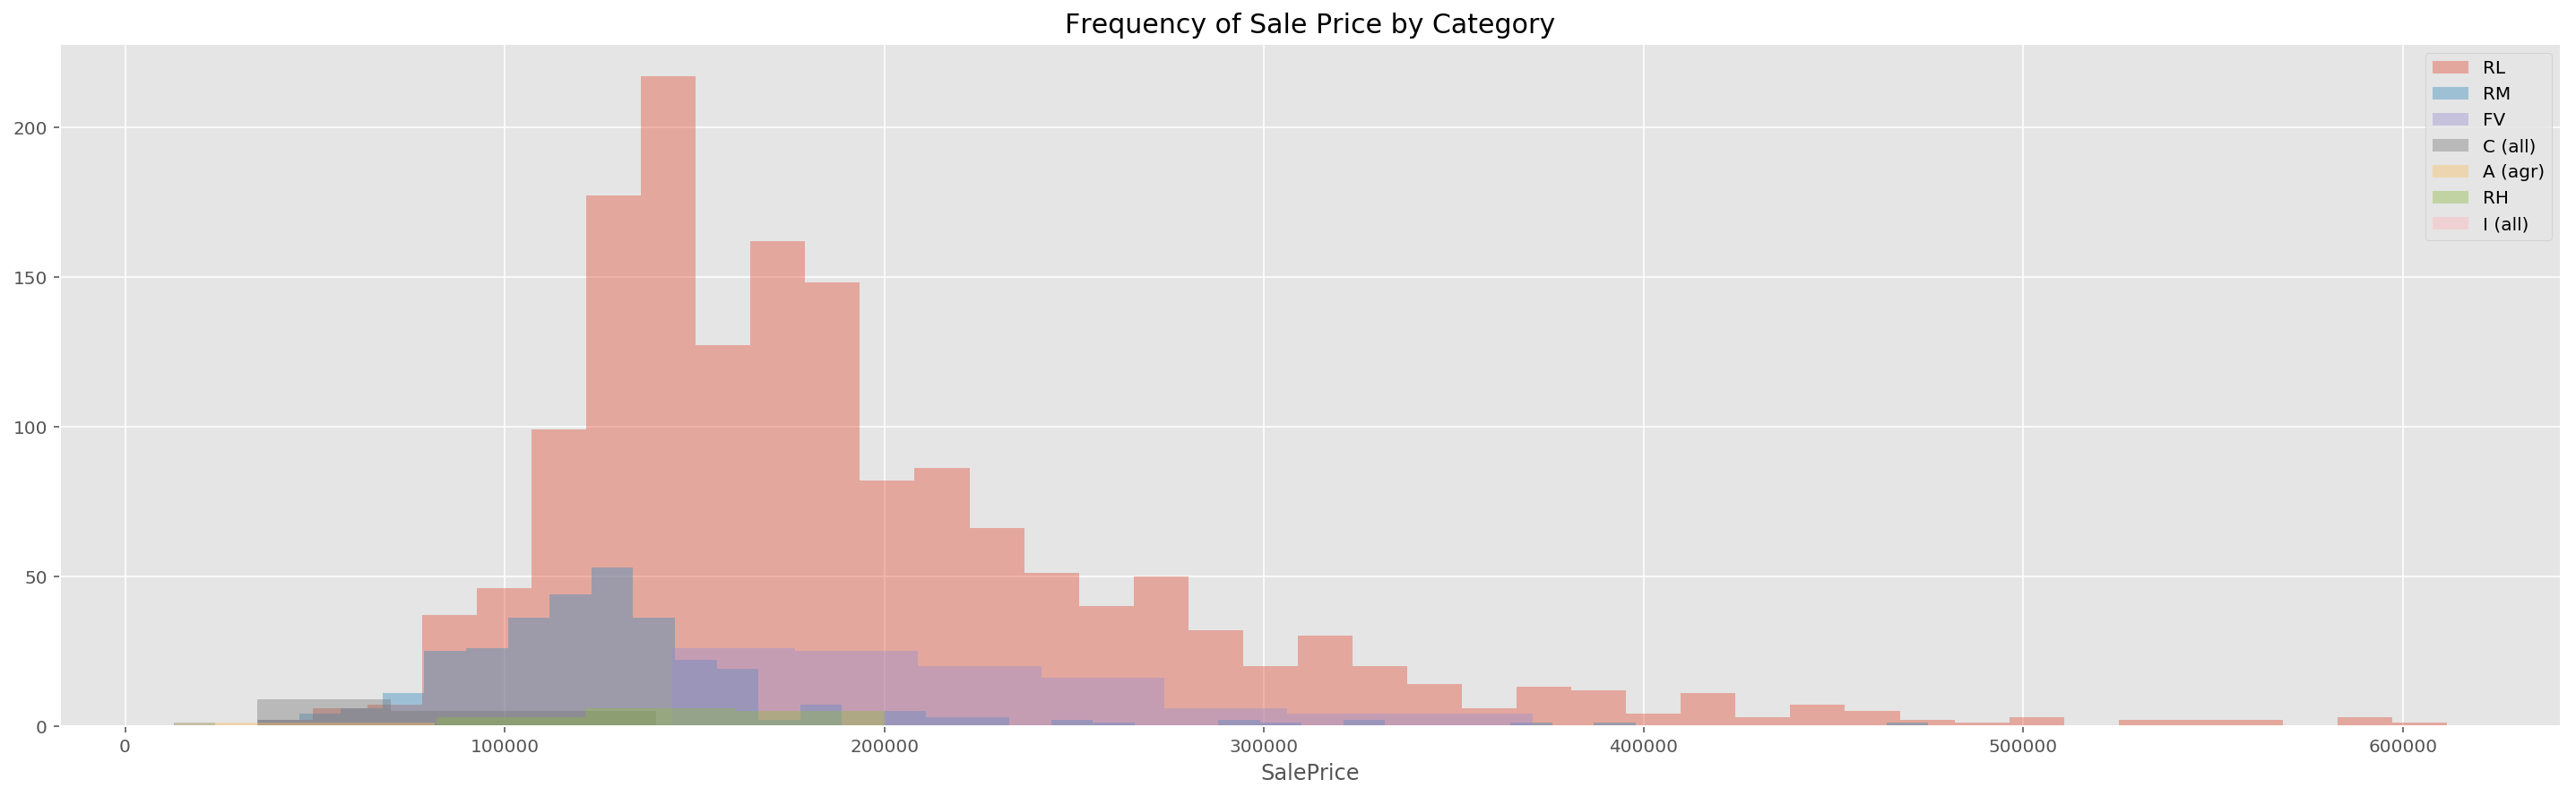

In [21]:
plt.figure(figsize=(25,7))
plt.title('Frequency of Sale Price by Category',fontsize=15)
for x in list(train_data1['MS Zoning'].unique()):
    sns.distplot(train_data1[train_data1['MS Zoning']==x]['SalePrice'],kde=False,label=x)
plt.legend()
plt.savefig('./graphs/price_class_distribution')

# Preprocessing

In [22]:
#mapping of the numerical grading for the ordinals columns

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

lot_shape_dict= {'Reg':4,'IR1':3,'IR2':2,'IR3':1}
train_data1['Lot Shape']=train_data1['Lot Shape'].map(lot_shape_dict)
utilities_dict= {'AllPub':4,'NoSewr':3,'NoSeWa':2,'ELO':1}
train_data1['Utilities']=train_data1['Utilities'].map(utilities_dict)
land_slope_dict= {'Gtl':3,'Mod':2,'Sev':1}
train_data1['Land Slope']=train_data1['Land Slope'].map(land_slope_dict)
exter_qual_dict= {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}
train_data1['Exter Qual']=train_data1['Exter Qual'].map(exter_qual_dict)
exter_cond_dict= {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}
train_data1['Exter Cond']=train_data1['Exter Cond'].map(exter_cond_dict)
bsmt_qual_dict= {'Ex':6,'Gd':5,'TA':4,'Fa':3,'Po':2,'NA':1}
train_data1['Bsmt Qual']=train_data1['Bsmt Qual'].map(bsmt_qual_dict)
bsmt_cond_dict= {'Ex':6,'Gd':5,'TA':4,'Fa':3,'Po':2,'NA':1}
train_data1['Bsmt Cond']=train_data1['Bsmt Cond'].map(bsmt_cond_dict)
heatingqc_dict= {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}
train_data1['Heating QC']=train_data1['Heating QC'].map(heatingqc_dict)
electrical_dict= {'SBrkr':5,'FuseA':4,'FuseF':3,'FuseP':2,'Mix':1}
train_data1['Electrical']=train_data1['Electrical'].map(electrical_dict)
kitchenqual_dict= {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}
train_data1['Kitchen Qual']=train_data1['Kitchen Qual'].map(kitchenqual_dict)
fireplacequ_dict= {'Ex':6,'Gd':5,'TA':4,'Fa':3,'Po':2,'NA':1}
train_data1['Fireplace Qu']=train_data1['Fireplace Qu'].map(fireplacequ_dict)
garage_finish_dict= {'Fin':4,'RFn':3,'Unf':2,'NA':1}
train_data1['Garage Finish']=train_data1['Garage Finish'].map(garage_finish_dict)
garage_qual_dict= {'Ex':6,'Gd':5,'TA':4,'Fa':3,'Po':2,'NA':1}
train_data1['Garage Qual']=train_data1['Garage Qual'].map(garage_qual_dict)
garage_cond_dict= {'Ex':6,'Gd':5,'TA':4,'Fa':3,'Po':2,'NA':1}
train_data1['Garage Cond']=train_data1['Garage Cond'].map(garage_cond_dict)
paved_drive_dict= {'Y':3,'P':2,'N':1}
train_data1['Paved Drive']=train_data1['Paved Drive'].map(paved_drive_dict)
bsmt_exposure_dict= {'Gd':5,'Av':5,'Mn':3,'No':2,'NA':1}
train_data1['Bsmt Exposure']=train_data1['Bsmt Exposure'].map(bsmt_exposure_dict)
pool_qc_dict= {'Ex':5,'Gd':4,'TA':3,'Fa':2,'NA':1}
train_data1['Pool QC']=train_data1['Pool QC'].map(pool_qc_dict)
fence_dict= {'GdPrv':5,'MnPrv':4,'GdWo':3,'MnWw':2,'NA':1}
train_data1['Fence']=train_data1['Fence'].map(fence_dict)
bsmtfin_type1_dict= {'GLQ':7,'ALQ':6,'BLQ':5,'Rec':4,'LwQ':3,'Unf':2,'NA':1}
train_data1['BsmtFin Type 1']=train_data1['BsmtFin Type 1'].map(bsmtfin_type1_dict)
bsmtfin_type2_dict= {'GLQ':7,'ALQ':6,'BLQ':5,'Rec':4,'LwQ':3,'Unf':2,'NA':1}
train_data1['BsmtFin Type 2']=train_data1['BsmtFin Type 2'].map(bsmtfin_type2_dict)
functional_dict= {'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1}
train_data1['Functional']=train_data1['Functional'].map(functional_dict)

In [23]:
#checking through each column to count the number of empty values and the frequency of all values. 
#Columns in consideration for leaving out due to either of the previous conditions mentioned are Utilities, Pool QC, Fence and Fireplace Qu
for x in train_data1[ordinal]:
    print(x)
    print(train_data1[x].value_counts())
    print(train_data1[x].value_counts().sum(),',',train_data1[x].isnull().sum())
    print( )

Lot Shape
4    1295
3     691
2      55
1       8
Name: Lot Shape, dtype: int64
2049 , 0

Utilities
4    2047
3       1
2       1
Name: Utilities, dtype: int64
2049 , 0

Land Slope
3    1951
2      88
1      10
Name: Land Slope, dtype: int64
2049 , 0

Overall Qual
5     563
6     506
7     431
8     250
4     159
9      77
3      29
10     21
2       9
1       4
Name: Overall Qual, dtype: int64
2049 , 0

Overall Cond
5    1166
6     368
7     270
8     101
4      70
3      35
9      29
2       6
1       4
Name: Overall Cond, dtype: int64
2049 , 0

Exter Qual
3    1247
4     697
5      79
2      26
Name: Exter Qual, dtype: int64
2049 , 0

Exter Cond
3    1776
4     215
2      49
5       7
1       2
Name: Exter Cond, dtype: int64
2049 , 0

Bsmt Qual
4.0    887
5.0    864
6.0    182
3.0     60
2.0      1
Name: Bsmt Qual, dtype: int64
1994 , 55

Bsmt Cond
4.0    1832
5.0      89
3.0      65
2.0       5
6.0       3
Name: Bsmt Cond, dtype: int64
1994 , 55

Bsmt Exposure
2.0    1339
5.0     4

In [24]:
#to fill up all the null values for the ordinal dataframe
train_data1['Pool QC'].fillna(value=1.0,inplace=True)
train_data1['Fireplace Qu'].fillna(value=1.0,inplace=True)
train_data1['Fence'].fillna(value=1.0,inplace=True)
train_data1['Garage Finish'].fillna(value=1.0,inplace=True)
train_data1['Garage Qual'].fillna(value=1.0,inplace=True)
train_data1['Garage Cond'].fillna(value=1.0,inplace=True)
train_data1['Bsmt Qual'].fillna(value=1.0,inplace=True)
train_data1['Bsmt Cond'].fillna(value=1.0,inplace=True)
train_data1['Bsmt Exposure'].fillna(value=1.0,inplace=True)
train_data1['BsmtFin Type 1'].fillna(value=1.0,inplace=True)
train_data1['BsmtFin Type 2'].fillna(value=1.0,inplace=True)
train_data1[ordinal].isnull().sum()

Lot Shape         0
Utilities         0
Land Slope        0
Overall Qual      0
Overall Cond      0
Exter Qual        0
Exter Cond        0
Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     0
BsmtFin Type 1    0
BsmtFin Type 2    0
Heating QC        0
Electrical        0
Kitchen Qual      0
Functional        0
Fireplace Qu      0
Garage Finish     0
Garage Qual       0
Garage Cond       0
Paved Drive       0
Pool QC           0
Fence             0
dtype: int64

In [25]:
#Checking the unique values and the frequency of the unique values for the nominal data columns.
for x in train_data1[nominal]:
    print(x)
    print(train_data1[x].value_counts())
    print(train_data1[x].value_counts().sum(),',',train_data1[x].isnull().sum())
    print( )

MS SubClass
20     769
60     393
50     198
120    132
30     101
70      90
160     88
80      86
90      75
190     46
85      28
75      16
45      11
180     11
40       4
150      1
Name: MS SubClass, dtype: int64
2049 , 0

MS Zoning
RL         1596
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MS Zoning, dtype: int64
2049 , 0

Street
Pave    2042
Grvl       7
Name: Street, dtype: int64
2049 , 0

Alley
Grvl    85
Pave    55
Name: Alley, dtype: int64
140 , 1909

Land Contour
Lvl    1843
HLS      85
Bnk      78
Low      43
Name: Land Contour, dtype: int64
2049 , 0

Lot Config
Inside     1502
Corner      347
CulDSac     131
FR2          60
FR3           9
Name: Lot Config, dtype: int64
2049 , 0

Neighborhood
NAmes      310
CollgCr    180
OldTown    163
Edwards    141
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
SawyerW     87
NWAmes      87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
Timber      4

In [26]:
#to fill the null values for the nominal data columns, not yet in place.
train_data1['Mas Vnr Type'].fillna(value='none',inplace=True)
train_data1['Garage Type'].fillna(value='none',inplace=True)
train_data1['Misc Feature'].fillna(value='none',inplace=True)
train_data1['Alley'].fillna(value='none',inplace=True)
train_data1[nominal].isnull().sum().sum()

MS SubClass      0
MS Zoning        0
Street           0
Alley            0
Land Contour     0
Lot Config       0
Neighborhood     0
Condition 1      0
Condition 2      0
Bldg Type        0
House Style      0
Roof Style       0
Roof Matl        0
Exterior 1st     0
Exterior 2nd     0
Mas Vnr Type     0
Foundation       0
Heating          0
Central Air      0
Bedroom AbvGr    0
Kitchen AbvGr    0
Garage Type      0
Misc Feature     0
Sale Type        0
dtype: int64

In [27]:
#Checking the unique values and the frequency of the unique values for the discrete data columns.
for x in train_data1[discrete]:
    print(x)
    print(train_data1[x].value_counts())
    print(train_data1[x].value_counts().sum(),',',train_data1[x].isnull().sum())
    print( )

Year Built
2005    102
2006     99
2007     78
2004     72
2003     64
1976     39
1977     38
1920     38
1999     37
2002     36
2000     36
1998     35
1958     35
2008     34
1978     32
1968     32
1959     31
1940     29
1967     28
1956     28
1954     28
1950     28
1993     27
1970     27
1994     26
1971     26
1910     26
1966     25
1995     25
1962     25
       ... 
1942      6
1981      6
1989      6
1890      5
1991      5
1918      4
1931      4
1934      4
1985      4
1912      3
1982      3
1880      3
1895      3
1932      3
1919      2
1917      2
1905      2
1901      2
1892      1
1898      1
1908      1
1896      1
2010      1
1875      1
1913      1
1911      1
1893      1
1885      1
1879      1
1872      1
Name: Year Built, Length: 113, dtype: int64
2049 , 0

Year Remod/Add
1950    262
2006    139
2007    123
2005    100
2004     83
2000     69
2003     68
2002     59
2008     54
1998     51
1999     46
1996     42
1994     41
1995     38
2001     35
1993    

In [28]:
#to fill the NaN for the discrete data columns
train_data1['Bsmt Full Bath'].fillna(value='NA',inplace=True)
train_data1['Bsmt Half Bath'].fillna(value='NA',inplace=True)
train_data1['Garage Yr Blt'].fillna(value='NA',inplace=True)
train_data1['Garage Cars'].fillna(value='NA',inplace=True)
train_data1[discrete].isnull().sum().sum()

Year Built        0
Year Remod/Add    0
Bsmt Full Bath    0
Bsmt Half Bath    0
Full Bath         0
Half Bath         0
TotRms AbvGrd     0
Fireplaces        0
Garage Yr Blt     0
Garage Cars       0
Mo Sold           0
Yr Sold           0
dtype: int64

# CONTINUOUS

In [29]:
#checking for the number of null values for the continuous variables
train_data1[continuous].isnull().sum()

Lot Frontage       330
Lot Area             0
Mas Vnr Area        22
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
1st Flr SF           0
2nd Flr SF           0
Low Qual Fin SF      0
Gr Liv Area          0
Garage Area          1
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
dtype: int64

In [30]:
#to replace the null values
train_data1['Mas Vnr Area'].fillna(value=0,inplace=True)
train_data1['BsmtFin SF 1'].fillna(value=0,inplace=True)
train_data1['BsmtFin SF 2'].fillna(value=0,inplace=True)
train_data1['Bsmt Unf SF'].fillna(value=0,inplace=True)
train_data1['Garage Area'].fillna(value=0,inplace=True)
train_data1['Total Bsmt SF'].fillna(value=0,inplace=True)
train_data1['Lot Frontage'].fillna(value=0,inplace=True)

In [31]:
#creation of train_data2 with all the dummy columns
train_data2 = pd.get_dummies(train_data1,columns = onehot,drop_first=True)
train_data2.head()

,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,SalePrice,Year Built_1875,Year Built_1879,Year Built_1880,Year Built_1885,Year Built_1890,Year Built_1892,Year Built_1893,Year Built_1895,Year Built_1896,Year Built_1898,Year Built_1900,Year Built_1901,Year Built_1905,Year Built_1908,Year Built_1910,Year Built_1911,Year Built_1912,Year Built_1913,Year Built_1914,Year Built_1915,Year Built_1916,Year Built_1917,Year Built_1918,Year Built_1919,Year Built_1920,Year Built_1921,Year Built_1922,Year Built_1923,Year Built_1924,Year Built_1925,Year Built_1926,Year Built_1927,Year Built_1928,Year Built_1929,Year Built_1930,Year Built_1931,Year Built_1932,Year Built_1934,Year Built_1935,Year Built_1936,Year Built_1937,Year Built_1938,Year Built_1939,Year Built_1940,Year Built_1941,Year Built_1942,Year Built_1945,Year Built_1946,Year Built_1947,Year Built_1948,Year Built_1949,Year Built_1950,Year Built_1951,Year Built_1952,Year Built_1953,Year Built_1954,Year Built_1955,Year Built_1956,Year Built_1957,Year Built_1958,Year Built_1959,Year Built_1960,Year Built_1961,Year Built_1962,Year Built_1963,Year Built_1964,Year Built_1965,Year Built_1966,Year Built_1967,Year Built_1968,Year Built_1969,Year Built_1970,Year Built_1971,Year Built_1972,Year Built_1973,Year Built_1974,Year Built_1975,Year Built_1976,Year Built_1977,Year Built_1978,Year Built_1979,Year Built_1980,Year Built_1981,Year Built_1982,Year Built_1983,Year Built_1984,Year Built_1985,Year Built_1986,Year Built_1987,Year Built_1988,Year Built_1989,Year Built_1990,Year Built_1991,Year Built_1992,Year Built_1993,Year Built_1994,Year Built_1995,Year Built_1996,Year Built_1997,Year Built_1998,Year Built_1999,Year Built_2000,Year Built_2001,Year Built_2002,Year Built_2003,Year Built_2004,Year Built_2005,Year Built_2006,Year Built_2007,Year Built_2008,Year Built_2009,Year Built_2010,Year Remod/Add_1951,Year Remod/Add_1952,Year Remod/Add_1953,Year Remod/Add_1954,Year Remod/Add_1955,Year Remod/Add_1956,Year Remod/Add_1957,Year Remod/Add_1958,Year Remod/Add_1959,Year Remod/Add_1960,Year Remod/Add_1961,Year Remod/Add_1962,Year Remod/Add_1963,Year Remod/Add_1964,Year Remod/Add_1965,Year Remod/Add_1966,Year Remod/Add_1967,Year Remod/Add_1968,Year Remod/Add_1969,Year Remod/Add_1970,Year Remod/Add_1971,Year Remod/Add_1972,Year Remod/Add_1973,Year Remod/Add_1974,Year Remod/Add_1975,Year Remod/Add_1976,Year Remod/Add_1977,Year Remod/Add_1978,Year Remod/Add_1979,Year Remod/Add_1980,Year Remod/Add_1981,Year Remod/Add_1982,Year Remod/Add_1983,Year Remod/Add_1984,Year Remod/Add_1985,Year Remod/Add_1986,Year Remod/Add_1987,Year Remod/Add_1988,Year Remod/Add_1989,Year Remod/Add_1990,Year Remod/Add_1991,Year Remod/Add_1992,Year Remod/Add_1993,Year Remod/Add_1994,Year Remod/Add_1995,Year Remod/Add_1996,Year Remod/Add_1997,Year Remod/Add_1998,Year Remod/Add_1999,Year Remod/Add_2000,Year Remod/Add_2001,Year Remod/Add_2002,Year Remod/Add_2003,Year Remod/Add_2004,Year Remod/Add_2005,Year Remod/Add_2006,Year Remod/Add_2007,Year Remod/Add_2008,Year Remod/Add_2009,Year Remod/Add_2010,Bsmt Full Bath_1.0,Bsmt Full Bath_2.0,Bsmt Full Bath_3.0,Bsmt Full Bath_NA,Bsmt Half Bath_1.0,Bsmt Half Bath_2.0,Bsmt Half Bath_NA,Full Bath_1,Full Bath_2,Full Bath_3,Full Bath_4,Half Bath_1,Half Bath_2,TotRms AbvGrd_3,TotRms AbvGrd_4,TotRms AbvGrd_5,TotRms AbvGrd_6,TotRms AbvGrd_7,TotRms AbvGrd_8,TotRms AbvGrd_9,TotRms AbvGrd_10,TotRms AbvGrd_11,TotRms AbvGrd_12,TotRms AbvGrd_13,TotRms AbvGrd_14,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4,Garage Yr Blt_1896.0,Garage Yr Blt_1900.0,Gar

Text(14.999999999999993, 0.5, 'Continuous & Ordinal Variables')

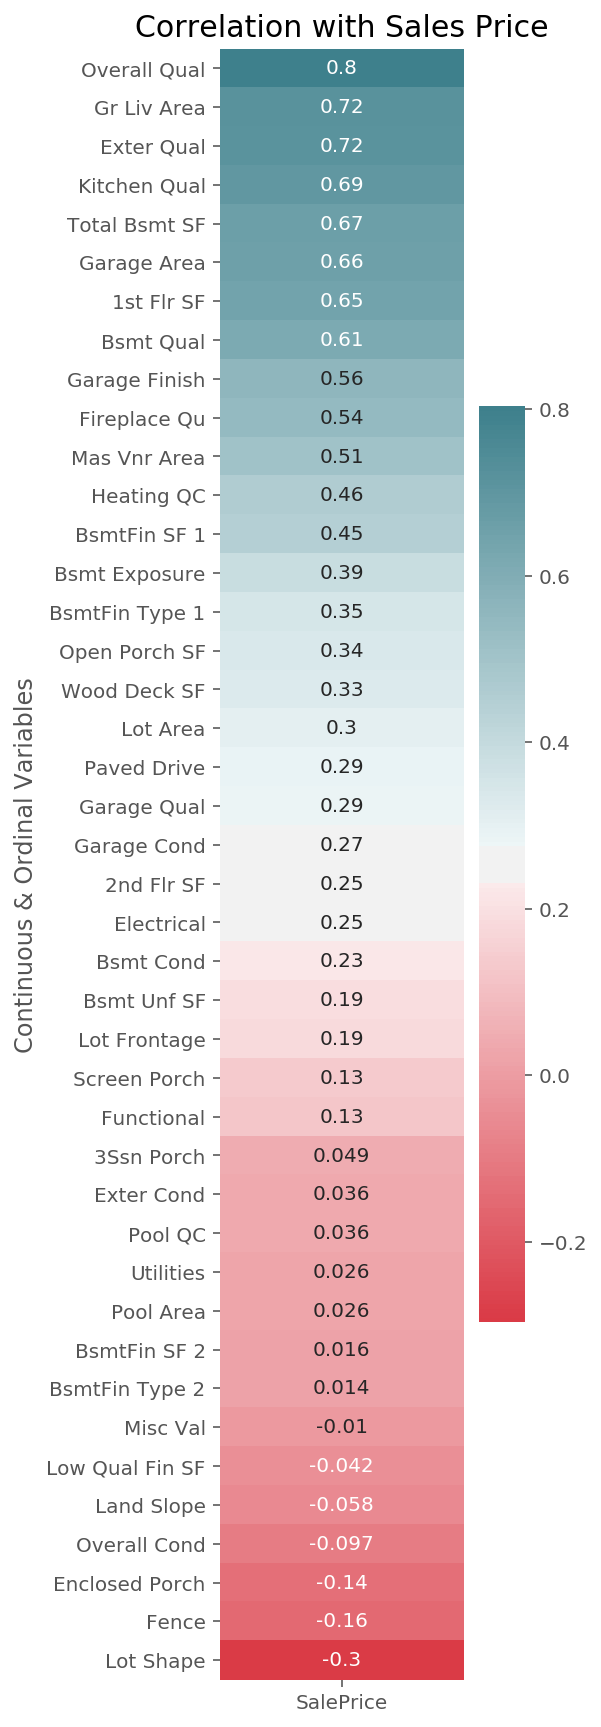

In [32]:
# Correlation heatmap of each continuous and ordinalvariable against the Sale Price
salesprice_corr=train_data2[ordcont+['SalePrice']].corr()[['SalePrice']].sort_values('SalePrice',ascending=False)
plt.figure(figsize=(4,15))
#plt.style.use("dark_background")
sns.heatmap(salesprice_corr[1:],cmap=sns.diverging_palette(730, 930, n=200,center = 'light'),annot=True)
plt.title('Correlation with Sales Price',fontsize=15)
plt.gcf().subplots_adjust(left=0.37)
plt.ylabel('Continuous & Ordinal Variables')
#plt.savefig('./graphs/ContOrd_heatmap_bb.png',quality = 95,facecolor="#1b212cff")

In [33]:
#creation of X_onehot to analyse the discrete/nominal variables to identify those with strong dependency with SalePrice
X_onehot = pd.get_dummies(train_data1[onehot].astype(str),drop_first=True)
y_onehot = train_data1['SalePrice']

#thresholder = VarianceThreshold(threshold=.2)
#X_high_variance = thresholder.fit_transform(X_onehot)
#pd.DataFrame(X_high_variance,y)

In [34]:
#test for dependency between all dummy variables and SalePrice
mir = mutual_info_regression(X_onehot,y_onehot)

In [35]:
dfmir=pd.DataFrame(mir,index=list(X_onehot.columns)).sort_values(by=0,ascending=False)

In [36]:
#checking the size of the number of dummies
X_onehot.shape

(2049, 485)

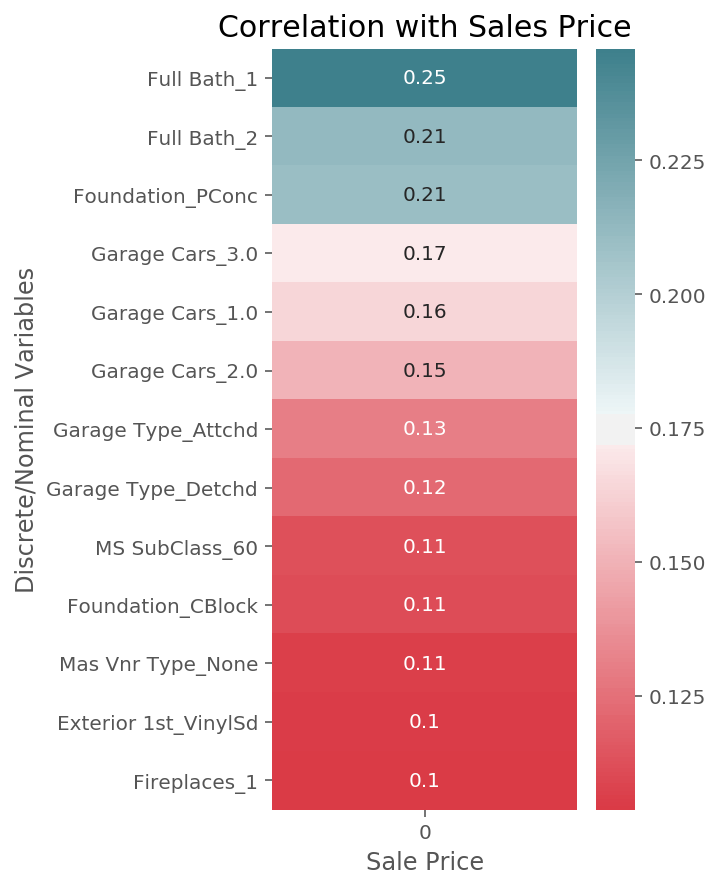

In [37]:
#Identifying strongly correlated binary and discrete variables (greater than 0.1)
plt.figure(figsize=(5,7))
sns.heatmap(dfmir.loc[(dfmir[0]>0.10)],cmap=sns.diverging_palette(730, 930, n=200),annot=True)
plt.xlabel('Sale Price')
plt.ylabel('Discrete/Nominal Variables')
plt.title('Correlation with Sales Price',fontsize=15)
plt.gcf().subplots_adjust(left=0.37)
#plt.savefig('./graphs/DisNom_heatmap_bb.png',quality = 95,facecolor="#1b212cff")

In [38]:
#selection of all the strongly correlated/dependent variables to be used in the regression (40 of them)
strong_list = list((salesprice_corr.loc[salesprice_corr['SalePrice']>0.3]).index)+list((salesprice_corr.loc[salesprice_corr['SalePrice']<-0.2]).index)+list((dfmir.loc[(dfmir[0]>0.15)]).index)
strong_list.remove('SalePrice')
train_data2[strong_list].columns

Index(['Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Kitchen Qual',
       'Total Bsmt SF', 'Garage Area', '1st Flr SF', 'Bsmt Qual',
       'Garage Finish', 'Fireplace Qu', 'Mas Vnr Area', 'Heating QC',
       'BsmtFin SF 1', 'Bsmt Exposure', 'BsmtFin Type 1', 'Open Porch SF',
       'Wood Deck SF', 'Lot Area', 'Lot Shape', 'Full Bath_1', 'Full Bath_2',
       'Foundation_PConc', 'Garage Cars_3.0', 'Garage Cars_1.0',
       'Garage Cars_2.0'],
      dtype='object')

# IMPORTING THE TEST DATA FOR MODELLING

In [40]:
#importing the test dataset and checking for the rows and columns.
test=pd.read_csv('./datasets/test.csv')
test.shape

(879, 80)

In [41]:
#to modify column 'Garage Cars' into float and to create dummy variables for the strongly correlated discrete/nominal columns
test['Garage Cars'] = test['Garage Cars'].astype(float)
test1 = pd.get_dummies(test,columns = onehot,drop_first=True)

In [42]:
#looking for null values in the 25 columns
test1[strong_list].isnull().sum()

Overall Qual          0
Gr Liv Area           0
Exter Qual            0
Kitchen Qual          0
Total Bsmt SF         0
Garage Area           0
1st Flr SF            0
Bsmt Qual            25
Garage Finish        45
Fireplace Qu        422
Mas Vnr Area          1
Heating QC            0
BsmtFin SF 1          0
Bsmt Exposure        25
BsmtFin Type 1       25
Open Porch SF         0
Wood Deck SF          0
Lot Area              0
Lot Shape             0
Full Bath_1           0
Full Bath_2           0
Foundation_PConc      0
Garage Cars_3.0       0
Garage Cars_1.0       0
Garage Cars_2.0       0
dtype: int64

In [43]:
#scoring the ordinal variables, defined earlier in the notebook.
test1['Lot Shape']=test1['Lot Shape'].map(lot_shape_dict)
test1['Utilities']=test1['Utilities'].map(utilities_dict)
test1['Land Slope']=test1['Land Slope'].map(land_slope_dict)
test1['Exter Qual']=test1['Exter Qual'].map(exter_qual_dict)
test1['Exter Cond']=test1['Exter Cond'].map(exter_cond_dict)
test1['Bsmt Qual']=test1['Bsmt Qual'].map(bsmt_qual_dict)
test1['Bsmt Cond']=test1['Bsmt Cond'].map(bsmt_cond_dict)
test1['Heating QC']=test1['Heating QC'].map(heatingqc_dict)
test1['Electrical']=test1['Electrical'].map(electrical_dict)
test1['Kitchen Qual']=test1['Kitchen Qual'].map(kitchenqual_dict)
test1['Fireplace Qu']=test1['Fireplace Qu'].map(fireplacequ_dict)
test1['Garage Finish']=test1['Garage Finish'].map(garage_finish_dict)
test1['Garage Qual']=test1['Garage Qual'].map(garage_qual_dict)
test1['Garage Cond']=test1['Garage Cond'].map(garage_cond_dict)
test1['Paved Drive']=test1['Paved Drive'].map(paved_drive_dict)
test1['Bsmt Exposure']=test1['Bsmt Exposure'].map(bsmt_exposure_dict)
test1['Pool QC']=test1['Pool QC'].map(pool_qc_dict)
test1['Fence']=test1['Fence'].map(fence_dict)
test1['BsmtFin Type 1']=test1['BsmtFin Type 1'].map(bsmtfin_type1_dict)
test1['BsmtFin Type 2']=test1['BsmtFin Type 2'].map(bsmtfin_type2_dict)
test1['Functional']=test1['Functional'].map(functional_dict)

In [44]:
#filling the null values for the required variables
test1['Bsmt Qual'].fillna(value=1.0,inplace=True)
test1['Fireplace Qu'].fillna(value=1.0,inplace=True)
test1['Fence'].fillna(value=1.0,inplace=True)
test1['Garage Finish'].fillna(value=1.0,inplace=True)
test1['Mas Vnr Area'].fillna(value=0,inplace=True)
test1['Garage Qual'].fillna(value=1.0,inplace=True)
test1['Garage Cond'].fillna(value=1.0,inplace=True)
test1['BsmtFin Type 2'].fillna(value=1.0,inplace=True)
test1['Pool QC'].fillna(value=1.0,inplace=True)
test1['Bsmt Cond'].fillna(value=1.0,inplace=True)
test1['Electrical'].fillna(value=1.0,inplace=True)
test1['Lot Frontage'].fillna(value=0,inplace=True)
test1['Bsmt Exposure'].fillna(value=1.0,inplace=True)
test1['BsmtFin Type 1'].fillna(value=1.0,inplace=True)
test1['BsmtFin Type 2'].fillna(value=1.0,inplace=True)

In [45]:
#final check that all null values are gone
test1[strong_list].isnull().sum().sum()

0

In [46]:
#standardizing the test data
test_sc = ss.transform(test1[strong_list])

## VANILLA LINEAR REGRESSION WITH 25 VARIABLES

In [39]:
#Standardising the 25 variable dataframe and performing the linear regression to produce the R-squared and RMSE
ss = StandardScaler()
lr=LinearRegression()

X_strong = ss.fit_transform(train_data2[strong_list])
y = train_data1['SalePrice']
lr.fit(X_strong,y)
lr_coefs=list(zip(strong_list,list(lr.coef_)))
lr_scores = np.sqrt(-cross_val_score(lr, X_strong, y, cv=10,scoring='neg_mean_squared_error'))
lr_r2 = cross_val_score(lr, X_strong, y, cv=10,scoring='r2')
print('AVERAGE R-SQUARED: ',sum(lr_r2)/len(lr_r2))
print('AVERAGE RMSE: ',sum(lr_scores)/len(lr_scores))
len(lr_coefs)

AVERAGE R-SQUARED:  0.8857552532571153
AVERAGE RMSE:  26687.977653685044


25

In [47]:
#predicting the score using the Vanilla Linear Regression model using the 25 variables
yhat=lr.predict(test_sc)

In [48]:
#saving the predictions to csv
pred_vanilla=pd.DataFrame(test['Id'],index=None)
pred_vanilla['SalePrice']=yhat
pred_vanilla['SalePrice']=round(pred_vanilla['SalePrice'],4)
#pred_vanilla.to_csv('./datasets/Predicted_Price_Vanilla_LR_25.csv', index=False)

# RIDGE REGRESSION WITH 25 VARIABLES

In [49]:
#Finding the optimal alpha for ridge
optimal_ridge = RidgeCV(alphas=np.logspace(0,5,100), cv=10)
optimal_ridge.fit(X_strong, y)
print(optimal_ridge.alpha_)

41.32012400115337


In [50]:
#Ridge Regression and the R-squared score and RMSE
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(X_strong,y)
ridge_coefs=list(zip(strong_list,list(ridge.coef_)))

ridge_scores = np.sqrt(-cross_val_score(ridge, X_strong, y, cv=10,scoring='neg_mean_squared_error'))
ridge_r2 = cross_val_score(ridge, X_strong, y, cv=10,scoring='r2')
print('AVERAGE R-SQUARED: ',sum(ridge_r2)/len(ridge_r2))
print('AVERAGE RMSE: ',sum(ridge_scores)/len(ridge_scores))
len(ridge_coefs)

AVERAGE R-SQUARED:  0.8860310930852361
AVERAGE RMSE:  26660.85430284841


25

In [51]:
#predicting and saving the output for submission
rd_yhat=ridge.predict(test_sc)
pred_vanilla_rd=pd.DataFrame(test['Id'],index=None)
pred_vanilla_rd['SalePrice']=rd_yhat
pred_vanilla_rd['SalePrice']=round(pred_vanilla_rd['SalePrice'],4)
#pred_vanilla_rd.to_csv('./datasets/Predicted_Price_Vanilla_RD_25.csv', index=False)

# LASSO REGRESSION WITH 25 VARIABLES

In [52]:
#Finding the optimal alpha for lasso
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(X_strong, y)
print(optimal_lasso.alpha_)

63.6957321814545


In [53]:
#Lasso Regression and the R-squared score and RMSE
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(X_strong,y)
lasso_coefs=list(zip(strong_list,list(lasso.coef_)))

lasso_scores = np.sqrt(-cross_val_score(lasso, X_strong, y, cv=10,scoring='neg_mean_squared_error'))
lasso_r2 = cross_val_score(lasso, X_strong, y, cv=10,scoring='r2')
print('AVERAGE R-SQUARED: ',sum(lasso_r2)/len(lasso_r2))
print('AVERAGE RMSE: ',sum(lasso_scores)/len(lasso_scores))
len(lasso_coefs)

AVERAGE R-SQUARED:  0.8857983389840338
AVERAGE RMSE:  26684.13284554933


25

In [54]:
#predicting and saving the output for submission
ls_yhat=lasso.predict(test_sc)
pred_vanilla_ls=pd.DataFrame(test['Id'],index=None)
pred_vanilla_ls['SalePrice']=ls_yhat
pred_vanilla_ls['SalePrice']=round(pred_vanilla_ls['SalePrice'],4)
#pred_vanilla_ls.to_csv('./datasets/Predicted_Price_Vanilla_LS_25.csv', index=False)

# Checks for near-zero or zero coefficients

In [56]:
#change in coeffficients when using Ridge and to identify if any coefficients were lowered towards zero
for f1 in lr_coefs:
    for f2 in ridge_coefs:
        if f1[0] == f2[0]:
            print(f1[0], f1[1], f2[1])
            print(round((f2[1]-f1[1]),4))

Overall Qual 16566.09123947924 15860.67729618043
-705.4139
Gr Liv Area 20565.5158116329 20307.24871268932
-258.2671
Exter Qual 8990.48698743844 8896.25845443634
-94.2285
Kitchen Qual 6992.661164212925 7132.04586204119
139.3847
Total Bsmt SF 4747.622781061297 4665.659108139062
-81.9637
Garage Area 4542.705233737199 4606.544499691663
63.8393
1st Flr SF 4673.468576765046 5034.247630460939
360.7791
Bsmt Qual 1951.4726520589384 2246.418873738239
294.9462
Garage Finish 2758.6044244979653 2794.7379800752597
36.1336
Fireplace Qu 3848.1918469646134 3995.4296572945204
147.2378
Mas Vnr Area 4627.313996928502 4702.270096421554
74.9561
Heating QC 2342.042708561728 2410.862508356554
68.8198
BsmtFin SF 1 10934.436192715211 10333.601867821459
-600.8343
Bsmt Exposure 2615.909009306199 2629.4819401123827
13.5729
BsmtFin Type 1 -653.2283638982146 -342.56551507882864
310.6628
Open Porch SF 1383.4809682444304 1458.6831399630173
75.2022
Wood Deck SF 1335.2195620036664 1473.1248805468347
137.9053
Lot Area 53

In [57]:
#change in coeffficients when using Lasso and to identify if any coefficients were changed to zero
for f1 in lr_coefs:
    for f2 in lasso_coefs:
        if f1[0] == f2[0]:
            print(f1[0], f1[1], f2[1])
            print((f2[1]-f1[1]))


Overall Qual 16566.09123947924 16520.00275211406
-46.08848736518121
Gr Liv Area 20565.5158116329 20764.356567308085
198.84075567518448
Exter Qual 8990.48698743844 9023.411089518577
32.924102080136436
Kitchen Qual 6992.661164212925 6989.499600770484
-3.161563442440638
Total Bsmt SF 4747.622781061297 4755.123306856773
7.500525795475369
Garage Area 4542.705233737199 4324.222271937526
-218.48296179967292
1st Flr SF 4673.468576765046 4716.462452517188
42.99387575214132
Bsmt Qual 1951.4726520589384 1924.984019397066
-26.488632661872316
Garage Finish 2758.6044244979653 2665.4029984229596
-93.20142607500566
Fireplace Qu 3848.1918469646134 3788.3975139318195
-59.79433303279393
Mas Vnr Area 4627.313996928502 4588.599716595647
-38.714280332855196
Heating QC 2342.042708561728 2309.352576662179
-32.69013189954876
BsmtFin SF 1 10934.436192715211 10714.86752117678
-219.56867153843086
Bsmt Exposure 2615.909009306199 2620.034892783553
4.125883477353909
BsmtFin Type 1 -653.2283638982146 -384.91000447213